数据网站，http://quotes.money.163.com/trade/lsjysj_zhishu_000001.html

结构如下：
日期	股票代码	名称	收盘价	最高价	最低价	开盘价	前收盘	涨跌额	涨跌幅	成交量	成交金额
每个交易日一条记录，从最后一天倒叙排列。

## Library

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


## Data Plot

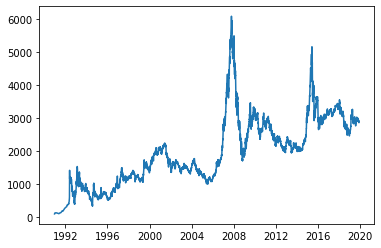

In [11]:
data = pd.read_csv('data/ashare/000001.csv', encoding='GBK', usecols = [0, 3, 4, 5, 6, 7, 11], converters={
    0:lambda x:datetime.strptime(x, '%Y-%m-%d')
})
# print(data)
data = data.sort_index(ascending=False)

training_set = data.iloc[:,1].values
timeline = data.iloc[:,0].values


plt.plot(timeline, training_set, )

plt.show()

In [12]:
def sliding_windows(data, seq_length, d):
    xx = []
    yy = []
    for i in range(len(data)-seq_length-d):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+d)]
        xx.append(_x)
        yy.append(_y)
    return np.array(xx), np.array(yy)

sc = MinMaxScaler()
print(training_set)
print(training_data.reshape(-1, 1))
training_data = sc.fit_transform(training_set.reshape(-1, 1))
print(training_data.shape)

num_classes = 1
seq_length = 6

x, y = sliding_windows(training_data, seq_length, num_classes)
print(x.shape)
print(y.shape)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
print(trainX.shape)
print(trainY.shape)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


# print(training_data)
# print(trainX)
# print(trainY)

[  99.98    104.39    109.13   ... 2903.1947 2889.6934 2871.9813]
[[0.68198842]
 [0.62717058]
 [0.62717058]
 ...
 [0.35342186]
 [0.34116445]
 [0.34286687]]
(7078, 1)
(7071, 6, 1)
(7071, 1, 1)
torch.Size([4737, 6, 1])
torch.Size([4737, 1, 1])


## Model

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x)#, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [15]:
num_epochs = 4000
learning_rate = 0.01

input_size = 1#training_set.shape[1]
hidden_size = 2
num_layers = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    outputs = outputs.view(-1, num_classes, 1)
#     print(outputs, trainY)
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 500 == 0:
        with torch.no_grad():
            outputs = lstm(testX)
            outputs = outputs.view(-1, num_classes, 1)
            loss_test = criterion(outputs, testY)

        print("Epoch: %d, train-loss: %1.5f, test-loss: %1.5f" % (epoch, loss.item(), loss_test.item()))

Epoch: 0, train-loss: 0.22464, test-loss: 0.41248
Epoch: 500, train-loss: 0.00022, test-loss: 0.00031
Epoch: 1000, train-loss: 0.00008, test-loss: 0.00010
Epoch: 1500, train-loss: 0.00005, test-loss: 0.00006
Epoch: 2000, train-loss: 0.00005, test-loss: 0.00006
Epoch: 2500, train-loss: 0.00005, test-loss: 0.00005
Epoch: 3000, train-loss: 0.00005, test-loss: 0.00005
Epoch: 3500, train-loss: 0.00005, test-loss: 0.00005


## Testing for Global CO2 Monthly Dataset

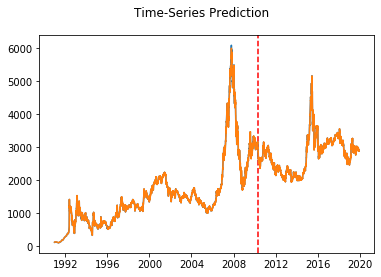

In [16]:
lstm.eval()
train_predict = lstm(dataX)
train_predict = train_predict.view(-1, 1)
dataY = dataY.view(-1, 1)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()
# print(dataY_plot)
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
# print(len(dataY_plot[:, 0]))

tx, ty = sliding_windows(timeline, seq_length, num_classes)

plt.axvline(x=ty[train_size], c='r', linestyle='--')

plt.plot(ty, dataY_plot, )
plt.plot(ty, data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()